In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download pevogam/ucf101

100% 6.48G/6.49G [01:09<00:00, 158MB/s]
100% 6.49G/6.49G [01:09<00:00, 99.9MB/s]


In [ ]:
! unzip ucf101.zip

Streaming output truncated to the last 5000 lines.
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c02.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c03.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c04.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c05.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g01_c06.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g02_c01.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g02_c02.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g02_c03.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g02_c04.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g03_c01.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g03_c02.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g03_c03.avi  
  inflating: UCF101/UCF-101/PlayingGuitar/v_PlayingGuitar_g03_c04.avi  
  inflating: 

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/content/UCF101'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g16_c05.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g15_c01.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g01_c03.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g15_c05.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g22_c04.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g20_c05.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g09_c04.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g17_c04.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g03_c06.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g05_c04.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g10_c01.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g24_c05.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g20_c03.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g10_c03.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g11_c01.avi
/content/UCF101/UCF-101/SalsaSpin/v_SalsaSpin_g07_c01.avi
/content/UCF101/UCF-1

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
label_data = pd.read_csv("UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)
label_data.head()

,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [ ]:
#Total Number of video folders for classification
len(label_data)

101

In [ ]:
path=[]
for label in label_data.labels.values:
    path.append('UCF101/UCF-101/'+label+"/")
path[0]

'UCF101/UCF-101/ApplyEyeMakeup/'

In [ ]:
#Function for Feature Extraction
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=5
    frames_list=[]
    video_reader = cv2.VideoCapture(video_path)

    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_interval = max(int(frame_count/sequence_length), 1)

    for counter in range(sequence_length):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)

        ret, frame = video_reader.read()
        if not ret:
            break;

        frame=cv2.resize(frame, (height, width))

        frames_list.append(frame)
    video_reader.release()

    return frames_list

In [ ]:
#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]

    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            video_path = os.path.join(folder, file)
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

In [ ]:
#Due to memory allocation problem. I will select last 60 video folders for classification
images, labels = load_video(path[41:])

100%|██████████| 128/128 [00:03<00:00, 33.79it/s]


In [ ]:
#Shapes
images.shape,pd.Series(labels).shape

((7832, 5, 60, 60, 3), (7832,))

In [ ]:
#Train Test Split
x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.06, random_state=40)
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((7362, 5, 60, 60, 3), (470, 5, 60, 60, 3), (7362,), (470,))

In [ ]:
max(y_train)

59

In [ ]:
model = Sequential()

model.add(Conv3D(filters = 16, kernel_size=(3,3,3), activation='LeakyReLU', data_format='channels_last',input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Conv3D(filters = 32, kernel_size=(2,2,2), activation='LeakyReLU', data_format='channels_last' ))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Conv3D(filters = 64, kernel_size=(2,2,2), activation='LeakyReLU', data_format='channels_last'))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Conv3D(filters = 128, kernel_size=(1,2,2), activation='LeakyReLU', data_format='channels_last' ))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Conv3D(filters = 256, kernel_size=(1,1,1), activation='LeakyReLU', data_format='channels_last' ))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(60, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 3, 58, 58, 16)     1312      
                                                                 
 max_pooling3d (MaxPooling3  (None, 3, 29, 29, 16)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 3, 29, 29, 16)     0         
 ributed)                                                        
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 28, 28, 32)     4128      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 14, 14, 32)     0         
 g3D)                                                            
                                                        

In [ ]:
#compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [ ]:
#Model training
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=31, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50
238/238 [==============================] - 17s 20ms/step - loss: 4.2988 - accuracy: 0.0580 - val_loss: 4.2062 - val_accuracy: 0.0553
Epoch 2/50
238/238 [==============================] - 4s 16ms/step - loss: 3.3537 - accuracy: 0.1729 - val_loss: 3.1936 - val_accuracy: 0.1957
Epoch 3/50
238/238 [==============================] - 3s 15ms/step - loss: 2.7911 - accuracy: 0.2651 - val_loss: 2.7369 - val_accuracy: 0.3191
Epoch 4/50
238/238 [==============================] - 3s 14ms/step - loss: 2.3774 - accuracy: 0.3574 - val_loss: 2.3415 - val_accuracy: 0.3745
Epoch 5/50
238/238 [==============================] - 4s 15ms/step - loss: 2.0503 - accuracy: 0.4420 - val_loss: 1.8212 - val_accuracy: 0.4936
Epoch 6/50
238/238 [==============================] - 4s 16ms/step - loss: 1.7870 - accuracy: 0.5086 - val_loss: 1.6352 - val_accuracy: 0.5681
Epoch 7/50
238/238 [==============================] - 3s 15ms/step - loss: 1.6156 - accuracy: 0.5467 - val_loss: 1.6381 - val_accuracy: 0.566

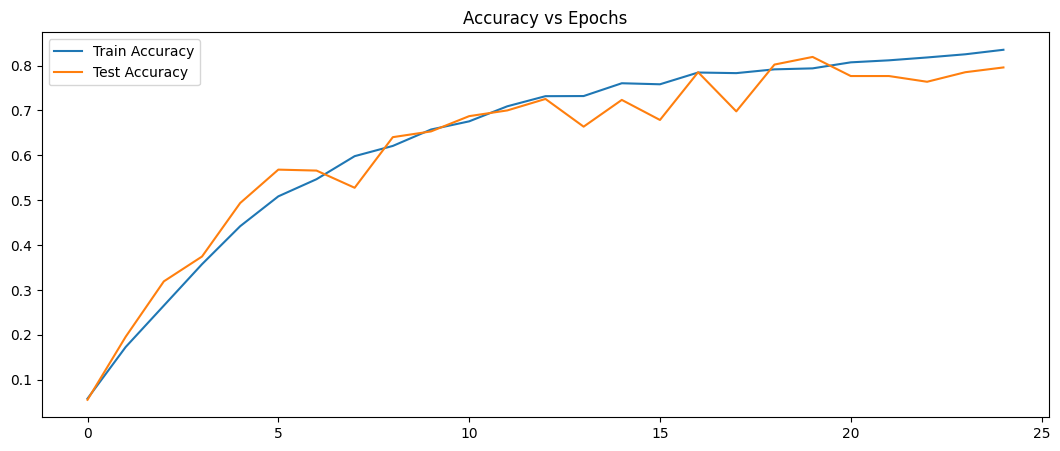

In [ ]:
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

15/15 [==============================] - 0s 13ms/step


In [ ]:
#Test Accuracy
accuracy_score(y_test, predicted_classes)

0.8191489361702128

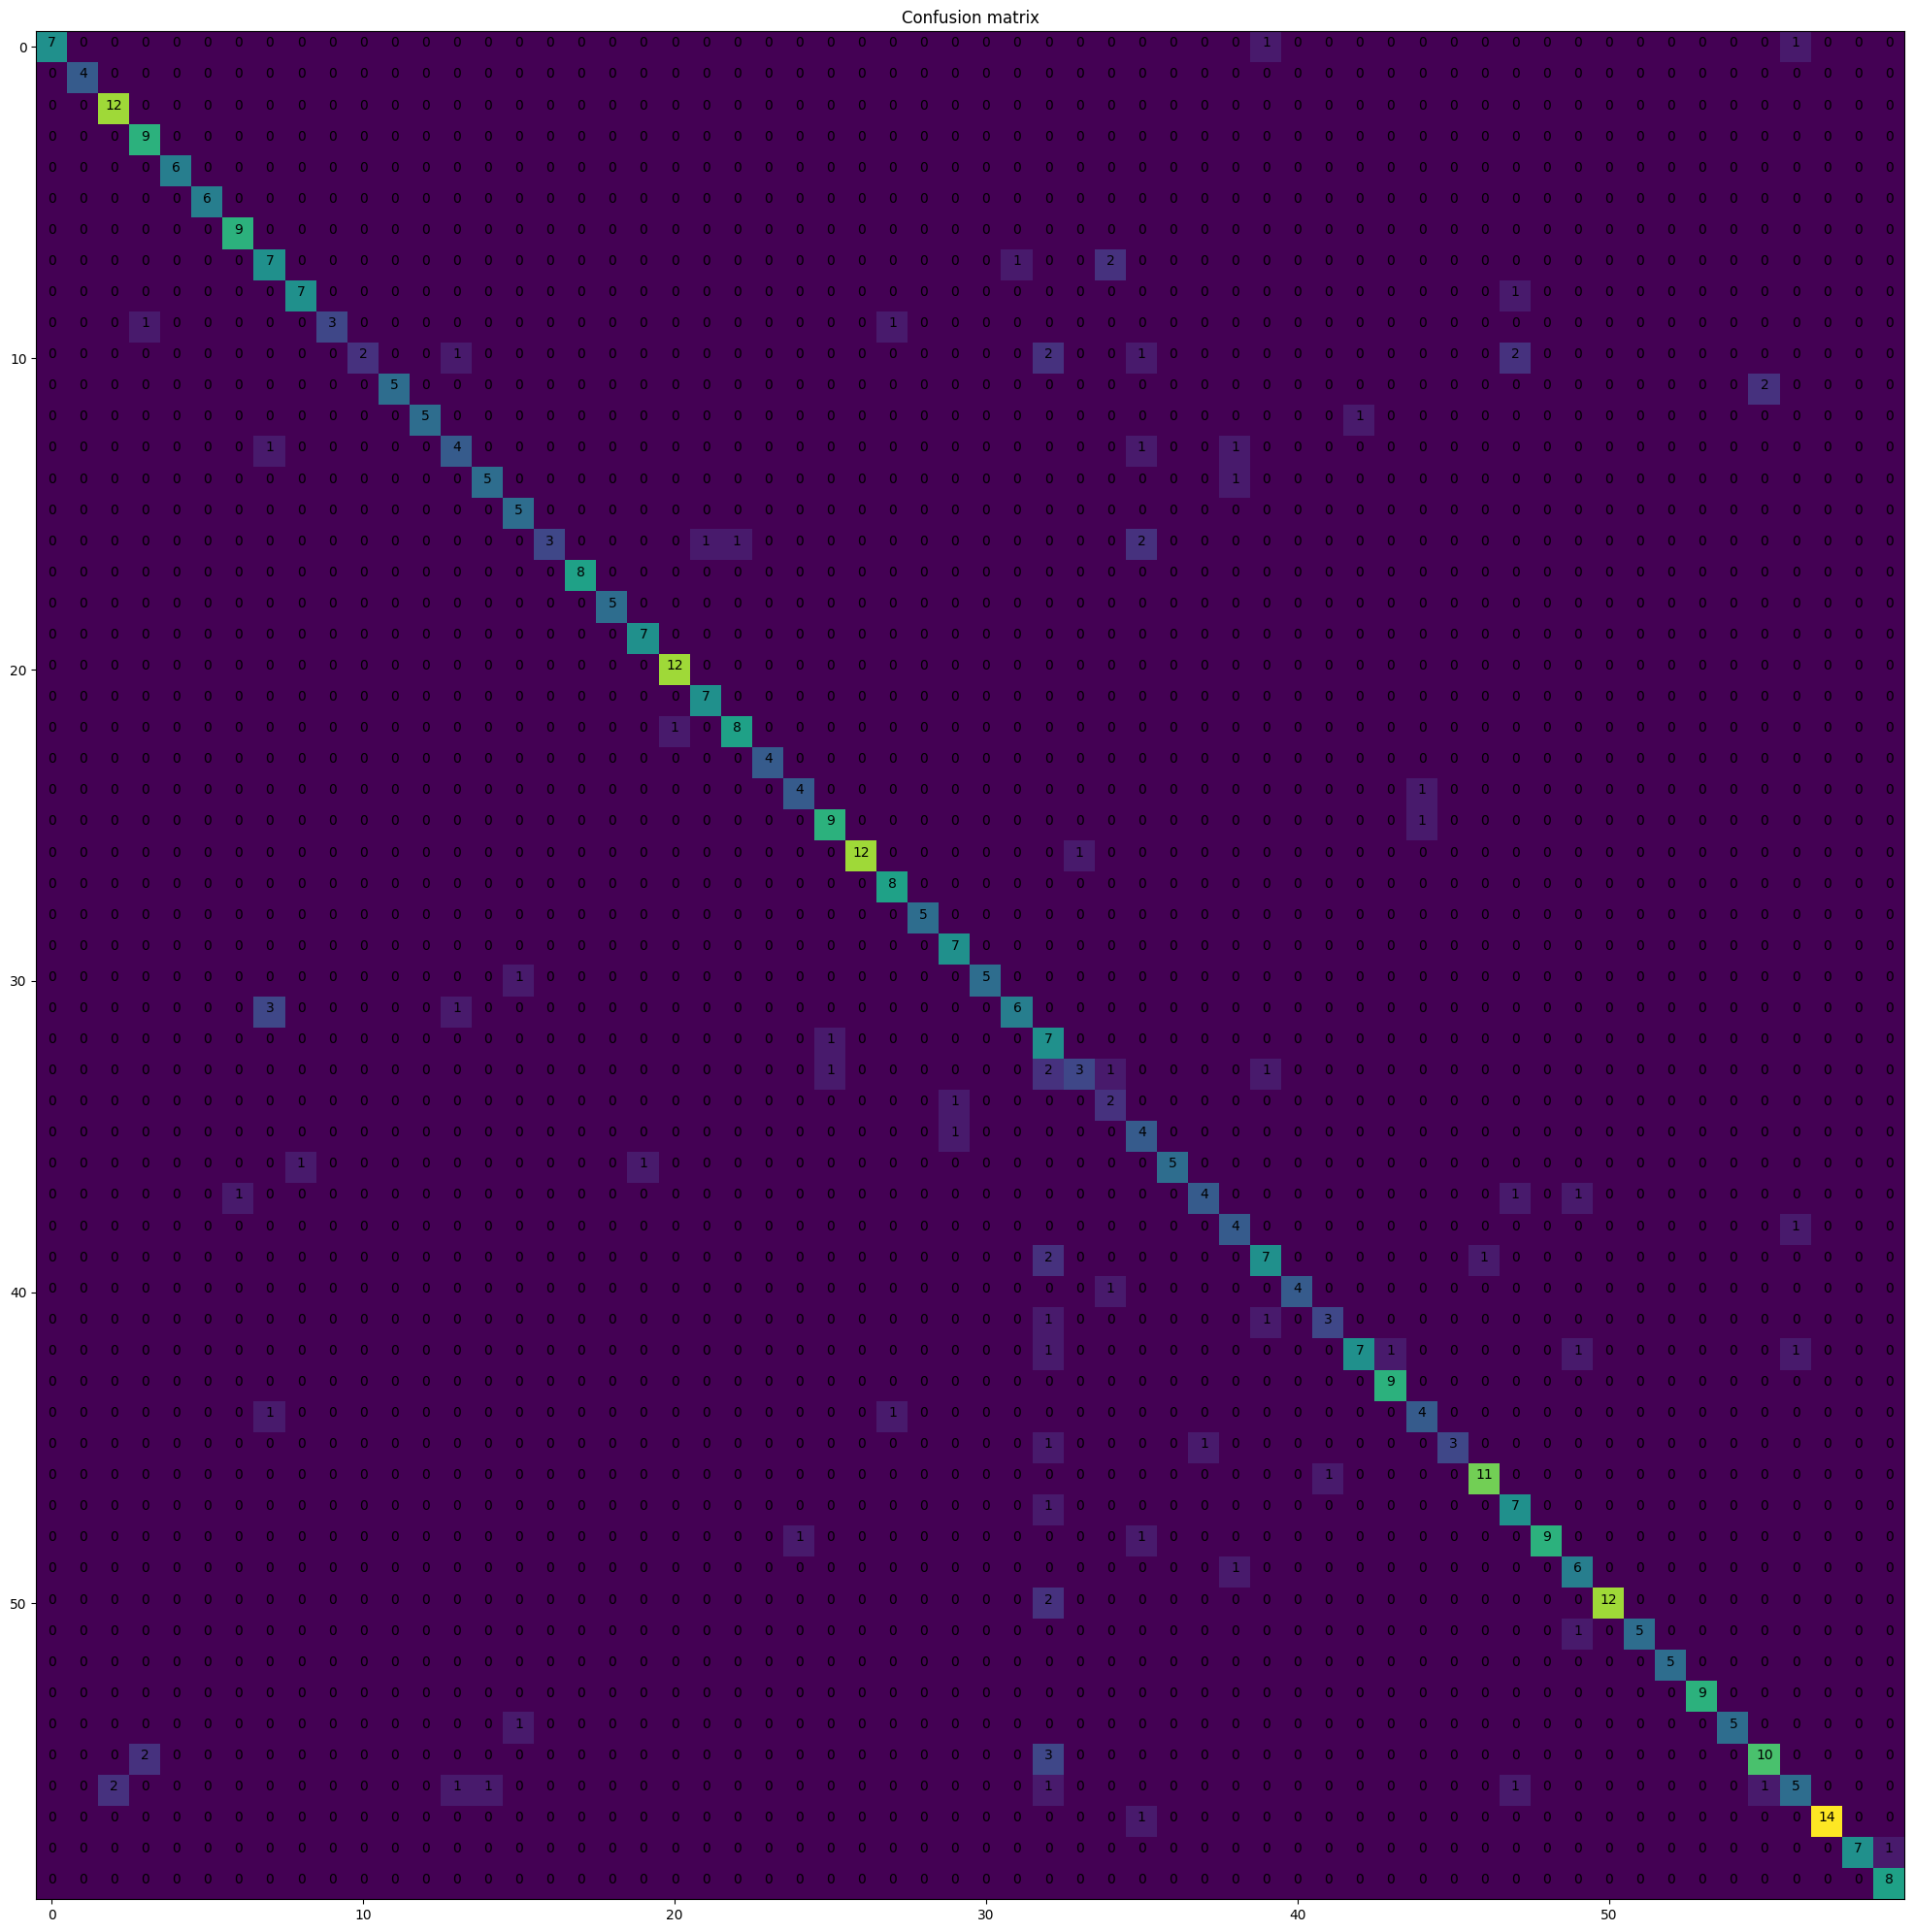

In [ ]:
#Confusion Matrix
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

In [ ]:
model.save('CNN_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
